In [1]:
%load_ext autoreload
%autoreload 2

from util_0731 import *
from myalgorithm_0731_1 import algorithm

## 실험 내용

- 스테이별 루트 및 주문 시간대 시각화

In [33]:
problem_file = r'C:\Users\hsh80\Desktop\LG CNS\stage1_problems\STAGE1_3.json'
problem_file = '../alg_test_problems_20240429/TEST_K50_1.json'

In [4]:

with open(problem_file, 'r') as f:
    prob = json.load(f)

K = prob['K']
ALL_RIDERS = [Rider(rider_info) for rider_info in prob['RIDERS']]

for v in ALL_RIDERS:
    print(v)

print(K)

Rider([BIKE, 5.291005291005291, 100, 60, 5000, 120, 40])
Rider([WALK, 1.3227513227513228, 70, 30, 5000, 120, 60])
Rider([CAR, 4.2328042328042335, 200, 100, 5000, 180, 200])
200


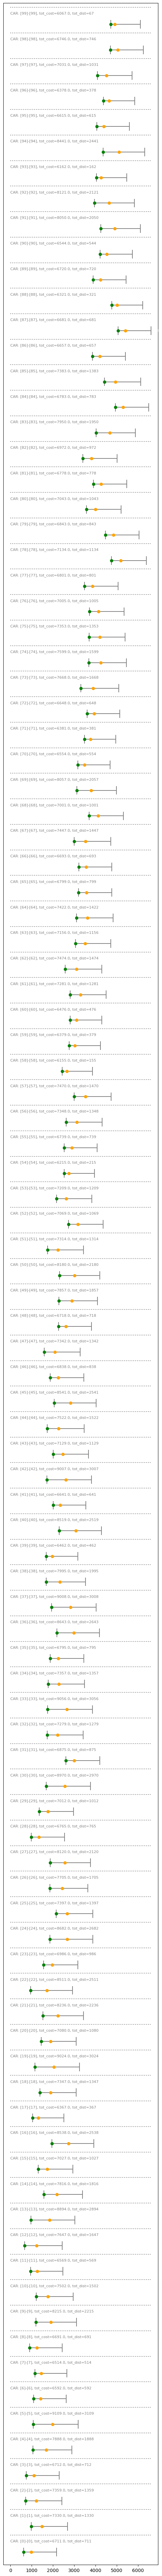

In [42]:
problem_file = r'C:\Users\hsh80\Desktop\LG CNS\stage1_problems\STAGE1_1.json'
# problem_file = '../alg_test_problems_20240429/TEST_K200_2.json'

## ------------------- 초기 상태 할당 코드 -------------------------

with open(problem_file, 'r') as f:
    prob = json.load(f)

K = prob['K']

ALL_ORDERS = [Order(order_info) for order_info in prob['ORDERS']]
ALL_RIDERS = [Rider(rider_info) for rider_info in prob['RIDERS']]

DIST = np.array(prob['DIST'])
for r in ALL_RIDERS:
    r.T = np.round(DIST/r.speed + r.service_time).astype(int)

inf = float('inf')

init_availables = [rider.available_number for rider in ALL_RIDERS]

car_rider = [rider for rider in ALL_RIDERS if rider.type == 'CAR'][0]
bike_rider = [rider for rider in ALL_RIDERS if rider.type == 'BIKE'][0]
walk_rider = [rider for rider in ALL_RIDERS if rider.type == 'WALK'][0]

all_bundles = []
for ord in ALL_ORDERS:
    new_bundle = Bundle(ALL_ORDERS, car_rider, [ord.id], [ord.id], ord.volume, DIST[ord.id, ord.id+K])
    car_rider.available_number -= 1
    all_bundles.append(new_bundle)

## -------------- 솔루션 제작 및 실현 가능성 확인 코드 ---------------- 

solution = [
        # rider type, shop_seq, dlv_seq
        [bundle.rider.type, bundle.shop_seq, bundle.dlv_seq]
        for bundle in all_bundles
]

with open(problem_file, 'r') as f:
    prob = json.load(f)

K = prob['K']

ALL_ORDERS = [Order(order_info) for order_info in prob['ORDERS']]
ALL_RIDERS = [Rider(rider_info) for rider_info in prob['RIDERS']]

DIST = np.array(prob['DIST'])
for r in ALL_RIDERS:
    r.T = np.round(DIST/r.speed + r.service_time).astype(int)

checked_solution = solution_check(K, ALL_ORDERS, ALL_RIDERS, DIST, solution)

draw_bundle_solution(ALL_ORDERS, ALL_RIDERS, DIST, checked_solution)

## 초기 코드

In [203]:
four_bundle_avg_method = 'two'

## ------------------- 초기 상태 할당 코드 -------------------------

with open(problem_file, 'r') as f:
    prob = json.load(f)

K = prob['K']

ALL_ORDERS = [Order(order_info) for order_info in prob['ORDERS']]
ALL_RIDERS = [Rider(rider_info) for rider_info in prob['RIDERS']]

DIST = np.array(prob['DIST'])
for r in ALL_RIDERS:
    r.T = np.round(DIST/r.speed + r.service_time).astype(int)

inf = float('inf')

car_rider = [rider for rider in ALL_RIDERS if rider.type == 'CAR'][0]
bike_rider = [rider for rider in ALL_RIDERS if rider.type == 'BIKE'][0]
walk_rider = [rider for rider in ALL_RIDERS if rider.type == 'WALK'][0]

init_availables = [rider.available_number for rider in ALL_RIDERS]

## ------------------  크루스칼 함수   -----------------------------

def kruskal_bundling(K, DIST, ALL_ORDERS, ALL_RIDERS, weight1, weight2, bundle_merging_function, order_count_upper_limit, avg_method, all_bundles, default_get_dist_function):
    def find(v):
        while v != parent[v]:
            parent[v] = parent[parent[v]]
            v = parent[v]

        return v

    def union(a, b, new_bundle):
        if a > b:
            a, b = b, a

        parent[b] = a
        all_bundles[a] = new_bundle

    for i in range(len(all_bundles)):
        bundle = all_bundles[i]

        shop_seq = bundle.shop_seq

        xs_s_sum = 0
        ys_s_sum = 0

        xs_e_sum = 0
        ys_e_sum = 0

        readytimes_sum = 0
        deadlines_sum = 0

        shop_seq_len = len(shop_seq)

        for order_num in shop_seq:
            order = ALL_ORDERS[order_num]

            xs_s_sum += order.shop_lat
            ys_s_sum += order.shop_lon

            xs_e_sum += order.dlv_lat
            ys_e_sum += order.dlv_lon

            readytimes_sum += order.ready_time
            deadlines_sum += order.deadline

        xs_s_avg = xs_s_sum / shop_seq_len
        ys_s_avg = ys_s_sum / shop_seq_len

        xs_e_avg = xs_e_sum / shop_seq_len
        ys_e_avg = ys_e_sum / shop_seq_len

        readytimes_avg = readytimes_sum / shop_seq_len
        deadlines_avg = deadlines_sum / shop_seq_len

        avg_info = [xs_s_avg, ys_s_avg, xs_e_avg, ys_e_avg, readytimes_avg, deadlines_avg]

        bundle.avg_info = avg_info

    edges = []
    for i in range(len(all_bundles)):
        for j in range(i + 1, len(all_bundles)):
            avg_info1 = all_bundles[i].avg_info
            avg_info2 = all_bundles[j].avg_info

            sx1, sy1, ex1, ey1, r1, d1 = avg_info1
            sx2, sy2, ex2, ey2, r2, d2 = avg_info2

            r_diff = abs(r1 - r2)
            d_diff = abs(d1 - d2)

            start_end_diff = default_get_dist_function((sx1 + sx2) / 2, (sy1 + sy2) / 2, (ex1 + ex2) / 2, (ey1 + ey2) / 2)

            if avg_method == 'avg':
                dist1 = default_get_dist_function(sx1, sy1, sx2, sy2)
                dist2 = default_get_dist_function(ex1, ey1, ex2, ey2)
            elif avg_method == 'two_seq':
                dist1 = DIST[i][j]
                dist2 = DIST[i + K][j + K]
            elif avg_method == 'two':
                order_num1 = all_bundles[i].shop_seq[0]
                order_num2 = all_bundles[j].shop_seq[0]

                dist1 = DIST[order_num1][order_num2]
                dist2 = DIST[order_num1 + K][order_num2 + K]  
            else:
                assert False

            # weight1 = (dist1 + dist2) / 900

            # diff_score = dist1 + dist2 + r_diff * weight1 + d_diff * weight1 + start_end_diff * weight2
            diff_score = dist1 + dist2 + r_diff * weight1 + d_diff * weight1 + start_end_diff * weight2

            edges.append((i, j, diff_score))

    parent = list(range(len(all_bundles)))
    edges.sort(key=lambda x: x[2])

    for bundle_num1, bundle_num2, diff_score in edges:
        rbn1, rbn2 = find(bundle_num1), find(bundle_num2)

        if rbn1 == rbn2:
            continue

        new_bundle = bundle_merging_function(K, DIST, ALL_ORDERS, ALL_RIDERS, all_bundles[rbn1], all_bundles[rbn2], order_count_upper_limit)

        if new_bundle is not None:
            all_bundles[rbn1].rider.available_number += 1
            all_bundles[rbn2].rider.available_number += 1
            
            new_bundle.rider.available_number -= 1

            union(rbn1, rbn2, new_bundle)

    parent = [find(v) for v in parent]

    result_bundles = [all_bundles[v] for v in set(parent)]
    rider_availables = [rider.available_number for rider in ALL_RIDERS]

    return result_bundles, rider_availables

## --------------- 초기 번들링 최적화 코드 --------------------------

weight1 = 1
weight2 = -2.5

bundle_merging_function = try_merging_bundles_by_dist
default_get_dist_function = get_dist_by_coords

inf = float('inf')

car_rider = [rider for rider in ALL_RIDERS if rider.type == 'CAR'][0]
bike_rider = [rider for rider in ALL_RIDERS if rider.type == 'BIKE'][0]
walk_rider = [rider for rider in ALL_RIDERS if rider.type == 'WALK'][0]

all_bundles = []
for ord in ALL_ORDERS:
    new_bundle = Bundle(ALL_ORDERS, car_rider, [ord.id], [ord.id], ord.volume, DIST[ord.id, ord.id+K])
    car_rider.available_number -= 1
    all_bundles.append(new_bundle)

# print('#2\n')

# 2개 주문 묶음 생성
all_bundles, rider_availables = kruskal_bundling(K, DIST, ALL_ORDERS, ALL_RIDERS, weight1, weight2, bundle_merging_function, 2, 'two_seq', all_bundles, default_get_dist_function)

# print('#4\n')

# 4개 주문 묶음 생성
all_bundles, rider_availables = kruskal_bundling(K, DIST, ALL_ORDERS, ALL_RIDERS, weight1, weight2, bundle_merging_function, 4, four_bundle_avg_method, all_bundles, default_get_dist_function)

# 2개 이하 주문이 묶인 번들을 전부 푼 다음 다시 생성
new_all_bundles = []
for bundle in all_bundles:
    if len(bundle.shop_seq) >= 3:
        new_all_bundles.append(bundle)
    else:
        old_rider = bundle.rider
        old_rider.available_number += 1
        for order_num in bundle.shop_seq:
            order = ALL_ORDERS[order_num]

            new_bundle = Bundle(ALL_ORDERS, car_rider, [order.id], [order.id], order.volume, DIST[order.id, order.id + K])
            car_rider.available_number -= 1
            new_all_bundles.append(new_bundle)

# print('#remain\n')

all_bundles, rider_availables = kruskal_bundling(K, DIST, ALL_ORDERS, ALL_RIDERS, weight1, weight2, bundle_merging_function, 3, 'two', new_all_bundles, default_get_dist_function)

## ------------------- 라이더 재배치 -------------------------------

all_bundles, rider_availables = reassign_riders(K, ALL_ORDERS, ALL_RIDERS, DIST, init_availables, all_bundles)
for rider_i in range(3):
    ALL_RIDERS[rider_i].available_number = rider_availables[rider_i]

## -------------- 솔루션 제작 및 실현 가능성 확인 코드 ---------------- 

solution = [
        # rider type, shop_seq, dlv_seq
        [bundle.rider.type, bundle.shop_seq, bundle.dlv_seq]
        for bundle in all_bundles
]

with open(problem_file, 'r') as f:
    prob = json.load(f)

K = prob['K']

ALL_ORDERS = [Order(order_info) for order_info in prob['ORDERS']]
ALL_RIDERS = [Rider(rider_info) for rider_info in prob['RIDERS']]

DIST = np.array(prob['DIST'])
for r in ALL_RIDERS:
    r.T = np.round(DIST/r.speed + r.service_time).astype(int)

checked_solution = solution_check(K, ALL_ORDERS, ALL_RIDERS, DIST, solution)

checked_solution['avg_cost']

3483.4699999999993

## 마감 시간과 주문 준비 시간의 차이를 이용한 개선 시도

In [202]:
## ------------------- 초기 상태 할당 코드 -------------------------

with open(problem_file, 'r') as f:
    prob = json.load(f)

K = prob['K']

ALL_ORDERS = [Order(order_info) for order_info in prob['ORDERS']]
ALL_RIDERS = [Rider(rider_info) for rider_info in prob['RIDERS']]

DIST = np.array(prob['DIST'])
for r in ALL_RIDERS:
    r.T = np.round(DIST/r.speed + r.service_time).astype(int)

inf = float('inf')

car_rider = [rider for rider in ALL_RIDERS if rider.type == 'CAR'][0]
bike_rider = [rider for rider in ALL_RIDERS if rider.type == 'BIKE'][0]
walk_rider = [rider for rider in ALL_RIDERS if rider.type == 'WALK'][0]

init_availables = [rider.available_number for rider in ALL_RIDERS]

## ------------------  크루스칼 함수   -----------------------------

def kruskal_bundling(K, DIST, ALL_ORDERS, ALL_RIDERS, weight1, weight2, bundle_merging_function, order_count_upper_limit, avg_method, all_bundles, default_get_dist_function, edge_index_limit):
    def find(v):
        while v != parent[v]:
            parent[v] = parent[parent[v]]
            v = parent[v]

        return v

    def union(a, b, new_bundle):
        if a > b:
            a, b = b, a

        parent[b] = a
        all_bundles[a] = new_bundle

    for i in range(len(all_bundles)):
        bundle = all_bundles[i]

        shop_seq = bundle.shop_seq

        xs_s_sum = 0
        ys_s_sum = 0

        xs_e_sum = 0
        ys_e_sum = 0

        readytimes_sum = 0
        deadlines_sum = 0

        shop_seq_len = len(shop_seq)

        for order_num in shop_seq:
            order = ALL_ORDERS[order_num]

            xs_s_sum += order.shop_lat
            ys_s_sum += order.shop_lon

            xs_e_sum += order.dlv_lat
            ys_e_sum += order.dlv_lon

            readytimes_sum += order.ready_time
            deadlines_sum += order.deadline

        xs_s_avg = xs_s_sum / shop_seq_len
        ys_s_avg = ys_s_sum / shop_seq_len

        xs_e_avg = xs_e_sum / shop_seq_len
        ys_e_avg = ys_e_sum / shop_seq_len

        readytimes_avg = readytimes_sum / shop_seq_len
        deadlines_avg = deadlines_sum / shop_seq_len

        avg_info = [xs_s_avg, ys_s_avg, xs_e_avg, ys_e_avg, readytimes_avg, deadlines_avg]

        bundle.avg_info = avg_info

    edges = []
    for i in range(len(all_bundles)):
        for j in range(i + 1, len(all_bundles)):
            avg_info1 = all_bundles[i].avg_info
            avg_info2 = all_bundles[j].avg_info

            sx1, sy1, ex1, ey1, r1, d1 = avg_info1
            sx2, sy2, ex2, ey2, r2, d2 = avg_info2

            r_diff = abs(r1 - r2)
            d_diff = abs(d1 - d2)

            start_end_diff = default_get_dist_function((sx1 + sx2) / 2, (sy1 + sy2) / 2, (ex1 + ex2) / 2, (ey1 + ey2) / 2)

            if avg_method == 'avg':
                dist1 = default_get_dist_function(sx1, sy1, sx2, sy2)
                dist2 = default_get_dist_function(ex1, ey1, ex2, ey2)
            elif avg_method == 'two_seq':
                dist1 = DIST[i][j]
                dist2 = DIST[i + K][j + K]
            elif avg_method == 'two':
                order_num1 = all_bundles[i].shop_seq[0]
                order_num2 = all_bundles[j].shop_seq[0]

                dist1 = DIST[order_num1][order_num2]
                dist2 = DIST[order_num1 + K][order_num2 + K]  
            else:
                assert False

            diff_score = dist1 + dist2 + r_diff * weight1 + d_diff * weight1 + start_end_diff * weight2

            edges.append((i, j, diff_score))

    parent = list(range(len(all_bundles)))
    edges.sort(key=lambda x: x[2])

    if edge_index_limit != 'all':
        edges = edges[:edge_index_limit]

    for bundle_num1, bundle_num2, diff_score in edges:
        rbn1, rbn2 = find(bundle_num1), find(bundle_num2)

        if rbn1 == rbn2:
            continue

        new_bundle = bundle_merging_function(K, DIST, ALL_ORDERS, ALL_RIDERS, all_bundles[rbn1], all_bundles[rbn2], order_count_upper_limit)

        if new_bundle is not None:
            all_bundles[rbn1].rider.available_number += 1
            all_bundles[rbn2].rider.available_number += 1
            
            new_bundle.rider.available_number -= 1

            union(rbn1, rbn2, new_bundle)

    parent = [find(v) for v in parent]

    result_bundles = [all_bundles[v] for v in set(parent)]
    rider_availables = [rider.available_number for rider in ALL_RIDERS]

    return result_bundles, rider_availables

## --------------- 초기 번들링 최적화 코드 --------------------------

weight1 = 1
weight2 = -1
weight3 = 1

avg_method = 'two'
bundle_merging_function = try_merging_bundles_by_dist
default_get_dist_function = get_dist_by_coords

inf = float('inf')

car_rider = [rider for rider in ALL_RIDERS if rider.type == 'CAR'][0]
bike_rider = [rider for rider in ALL_RIDERS if rider.type == 'BIKE'][0]
walk_rider = [rider for rider in ALL_RIDERS if rider.type == 'WALK'][0]

all_bundles = []
for ord in ALL_ORDERS:
    new_bundle = Bundle(ALL_ORDERS, car_rider, [ord.id], [ord.id], ord.volume, DIST[ord.id, ord.id+K])
    car_rider.available_number -= 1
    all_bundles.append(new_bundle)

# 2개 주문 묶음 생성
all_bundles, rider_availables = kruskal_bundling(K, DIST, ALL_ORDERS, ALL_RIDERS, weight1, weight2, bundle_merging_function, 2, 'two_seq', all_bundles, default_get_dist_function, 'all')

# 4개 주문 묶음 생성
all_bundles, rider_availables = kruskal_bundling(K, DIST, ALL_ORDERS, ALL_RIDERS, weight1, weight2, bundle_merging_function, 4, 'avg', all_bundles, default_get_dist_function, 'all')

# 3개 이하 주문이 묶인 번들을 전부 푼 다음 다시 생성
new_all_bundles = []
for bundle in all_bundles:
    if len(bundle.shop_seq) >= 3:
        new_all_bundles.append(bundle)
    else:
        old_rider = bundle.rider
        old_rider.available_number += 1
        for order_num in bundle.shop_seq:
            order = ALL_ORDERS[order_num]

            new_bundle = Bundle(ALL_ORDERS, car_rider, [order.id], [order.id], order.volume, DIST[order.id, order.id + K])
            car_rider.available_number -= 1
            new_all_bundles.append(new_bundle)


all_bundles, rider_availables = kruskal_bundling(K, DIST, ALL_ORDERS, ALL_RIDERS, weight1, weight2, bundle_merging_function, 3, 'two', new_all_bundles, default_get_dist_function, K * 10)
all_bundles, rider_availables = kruskal_bundling(K, DIST, ALL_ORDERS, ALL_RIDERS, weight1, weight2, bundle_merging_function, 3, 'two', all_bundles, default_get_dist_function, K * 100)
all_bundles, rider_availables = kruskal_bundling(K, DIST, ALL_ORDERS, ALL_RIDERS, weight1, weight2, bundle_merging_function, 3, 'two', all_bundles, default_get_dist_function, 'all')

## ------------------- 라이더 재배치 -------------------------------

all_bundles, rider_availables = reassign_riders(K, ALL_ORDERS, ALL_RIDERS, DIST, init_availables, all_bundles)
for rider_i in range(3):
    ALL_RIDERS[rider_i].available_number = rider_availables[rider_i]

## -------------- 솔루션 제작 및 실현 가능성 확인 코드 ---------------- 

solution = [
        # rider type, shop_seq, dlv_seq
        [bundle.rider.type, bundle.shop_seq, bundle.dlv_seq]
        for bundle in all_bundles
]

with open(problem_file, 'r') as f:
    prob = json.load(f)

K = prob['K']

ALL_ORDERS = [Order(order_info) for order_info in prob['ORDERS']]
ALL_RIDERS = [Rider(rider_info) for rider_info in prob['RIDERS']]

DIST = np.array(prob['DIST'])
for r in ALL_RIDERS:
    r.T = np.round(DIST/r.speed + r.service_time).astype(int)

checked_solution = solution_check(K, ALL_ORDERS, ALL_RIDERS, DIST, solution)

checked_solution['avg_cost']

3427.6644999999994